### Run this notebook first to run sanity checks on your data.  If this script encounters issues, consider transforming the data to resolve them prior to running the regression analysis. 

In [19]:
import os
import sys

In [20]:
sys.path.insert(0, os.path.join("..", ".."))
sys.path.append(os.path.join("..", "..", "impl", "lightweight_mmm"))

In [21]:
import numpy as np
import pandas as pd

In [22]:
from base_driver.config import load_config
from mmm.data.data_to_fit import DataToFit
from mmm.parser.csv import parse_csv_generic
from mmm.transform.transform import transform_input_generic

In [23]:
from lightweight_mmm import preprocessing

In [24]:
import plotly.express as px

In [25]:
pd.options.display.float_format = '{:,.3f}'.format

#### Update `config_filename` and `input_filename` to refer to your config and data files.

In [26]:
config_filename = "../sample_config.yaml"
input_filename = "../sample_data.csv"

In [27]:
_, config = load_config(config_filename)
data_dict = parse_csv_generic(input_filename, config)
input_data = transform_input_generic(data_dict, config)
data_to_fit = DataToFit.from_input_data(input_data, config)

In [28]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=np.vstack((data_to_fit.media_data_train_scaled, data_to_fit.media_data_test_scaled)),
    target_data=np.hstack((data_to_fit.target_train_scaled, data_to_fit.target_test_scaled)),
    cost_data=data_to_fit.media_priors_scaled,
    extra_features_data=np.vstack((data_to_fit.extra_features_train_scaled, data_to_fit.extra_features_test_scaled))
)

In [29]:
def highlight_variances(x: float, 
                        low_variance_threshold: float=1.0e-3, 
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

#### Variances below `low_variance_threshold` or above `high_variance_threshold` are highlighted in red.
#### If this happens, consider possible transformations to your data to reduce variance (such as combining channels or taking the log).
#### The "`feature_x`" rows refer to the media channels.

In [30]:
variances.style.applymap(highlight_variances)

,geo_0
feature_0,0.005700
feature_1,0.004908
feature_2,0.005007
extra_feature_0,0.044811


#### Spends must be positive.

In [31]:
spend_fractions.style.applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.166800
feature_1,0.333000
feature_2,0.500200


#### If `variance inflation factor` is at or above `high_vif_threshold`, consider merging or dropping features.

In [32]:
variance_inflation_factors.style.applymap(highlight_high_vif_values)

,geo_0
feature_0,1.017879
feature_1,1.012199
feature_2,1.013035
extra_feature_0,1.008492


In [33]:
per_observation_df, _ = data_to_fit.to_data_frame(unscaled=True)
per_observation_df.head(5)

,Ad Platform 1 volume,Ad Platform 2 volume,Ad Platform 3 volume,Ad Platform 1 cost,Ad Platform 2 cost,Ad Platform 3 cost,extra_feature_1,kpi
2023-01-01,"18,391.000","20,079.002","19,621.000",189.500,422.480,623.630,4.940,87.000
2023-01-02,"20,391.998","19,307.000","19,490.000",204.490,394.300,615.240,5.110,87.000
2023-01-03,"21,157.000","18,604.000","20,310.000",213.520,392.840,635.790,5.970,89.000
2023-01-04,"19,782.000","20,753.000","19,784.000",207.150,421.270,609.840,3.570,91.000
2023-01-05,"18,710.000","19,716.000","20,815.002",202.360,418.500,667.440,6.970,90.000


In [34]:
corr_df = per_observation_df[[column for column in per_observation_df.columns if column.find("volume") > 0 or column == input_data.target_name]]

#### If absolute values are >= 0.7, the regression analysis is likely to suffer from multicollinearity.  Consider merging features or applying other transformations.

In [35]:
corr_df.corr()

,Ad Platform 1 volume,Ad Platform 2 volume,Ad Platform 3 volume,kpi
Ad Platform 1 volume,1.000,-0.074,-0.101,0.317
Ad Platform 2 volume,-0.074,1.000,0.047,-0.256
Ad Platform 3 volume,-0.101,0.047,1.000,0.133
kpi,0.317,-0.256,0.133,1.000


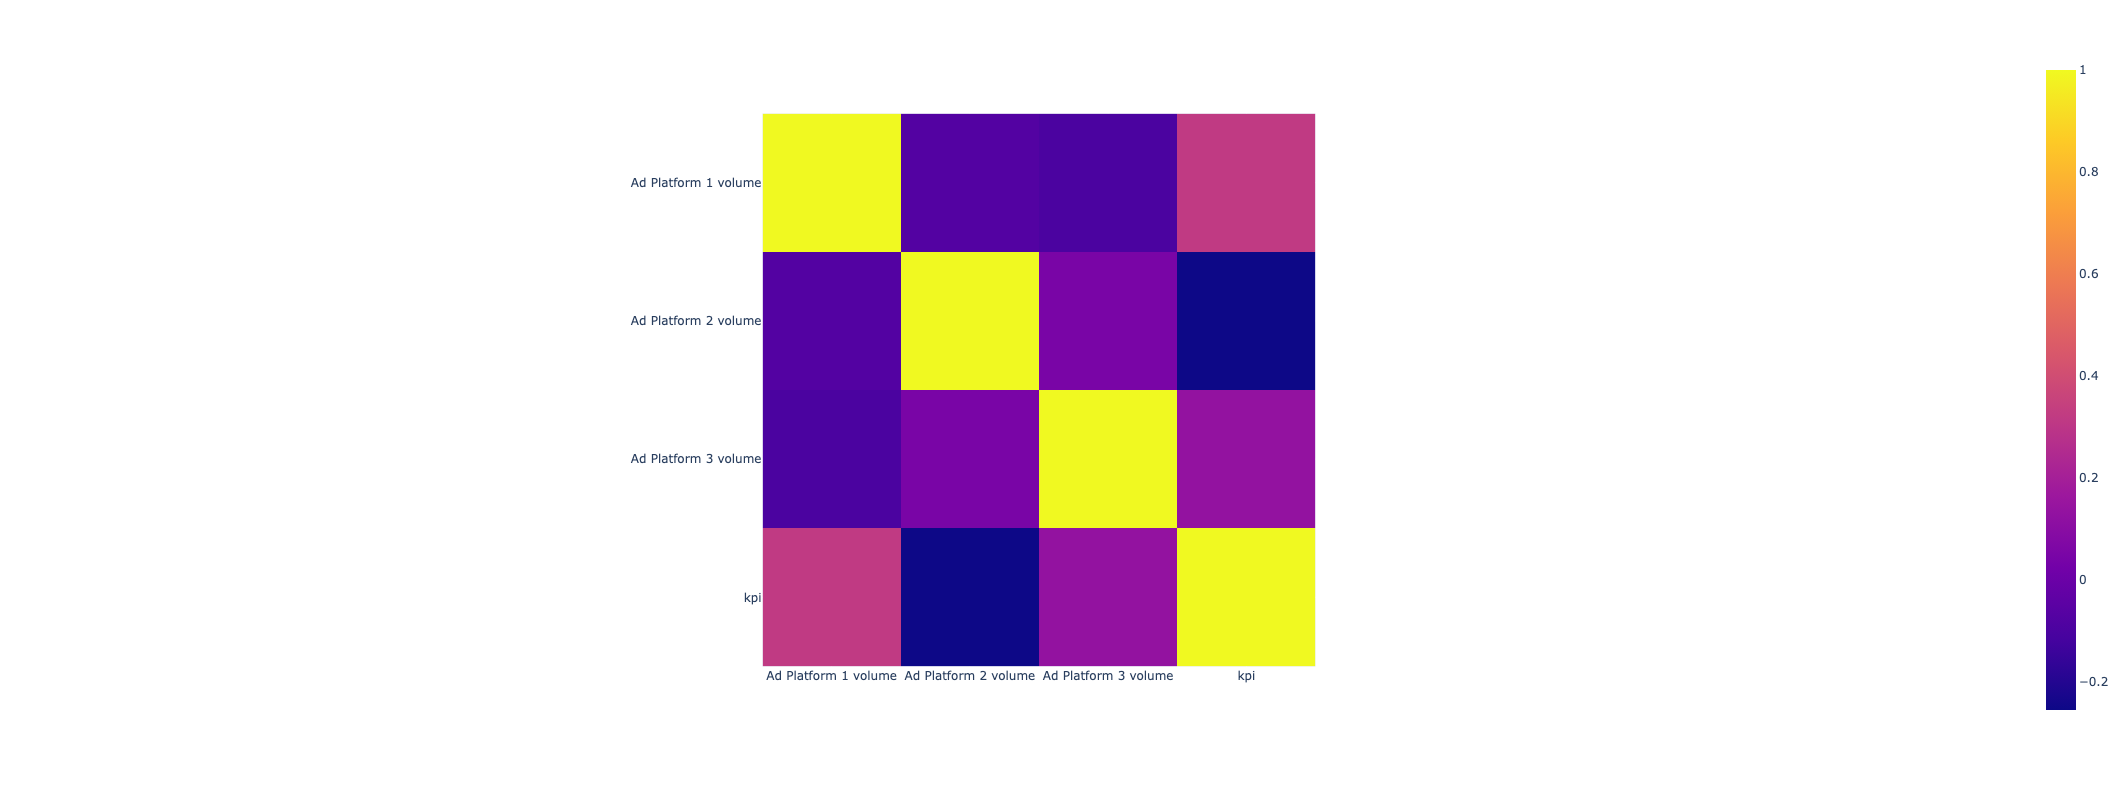

In [36]:
px.imshow(corr_df.corr(), width=800, height=800)